In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf

In [2]:
now = datetime.now()
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# Read exams data and initial parameters
data = pd.read_csv('csv/exames.csv')
data['int_covid'] = 0
data.loc[data['covid'] == 'POSITIVE', 'int_covid'] = 1

FOLDER_TEST = "exame-pulmao"
TRAIN_IMG_SRC_FOLDER = "/ssd/share/Classificacao/Abordagem3D-Comba/input/" + FOLDER_TEST

VALIDATION_IMG_SRC_FOLDER = "/ssd/share/Classificacao/Abordagem3D-Comba/input/" + FOLDER_TEST
SUB_FILE = ['axis1', 'axis2', 'axis3', 'axis4']

CLASSES = len(set([label for label in ['POSITIVE', 'NEGATIVE']]))
EPOCHS = 5
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_CHANNELS = 3
SELECTED_MODEL = ''



In [4]:
'''Split into Data for training/validation, and TEST, save as files'''
def get_dataset_trainval_test(data, filename_complement):
    data_pos = data[data.covid == 'POSITIVE']
    data_neg = data[data.covid == 'NEGATIVE']

    data_pos_train, data_pos_test, _, _ = train_test_split(data_pos, data_pos, test_size=0.05)
    data_neg_train, data_neg_test, _, _ = train_test_split(data_neg, data_neg, test_size=0.1)

    # Data for TEST
    data_test = data_pos_test.append(data_neg_test)
    # Data for training/val
    data_tv = data_pos_train.append(data_neg_train)

    data_tv.to_csv('csv/data_tv_'+filename_complement+'.csv')
    data_test.to_csv('csv/data_test_'+filename_complement+'.csv')
    return(data_tv, data_test)

In [5]:
def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(set_number, cur_subfile, data_train, data_test):
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
#     subset_imgs_folder_val = LIST_IMG_FOLDERS[set_number * 4:(set_number+1) * 4]
    
    LIST_IMG_FOLDERS = data['nome'].to_list()
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row['covid']

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row['covid']
    
#     print(TRAIN_IMG_FOLDERS_SLICE)
#     print(VALIDATION_IMG_FOLDERS_SLICE)
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))

    train_df, validation_df = dfs[0], dfs[1]

    train_df.to_csv('train_df_'+str(set_number)+'.csv', index=False)
    validation_df.to_csv('validation_df_'+str(set_number)+'.csv', index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [6]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [7]:
#show_gallery("all")

In [8]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
#     fill_mode='constant',
#     cval=0
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

In [9]:
def get_model():
    with tf.device('/GPU:0'):
#         inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#         s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
        
        classifier = tf.keras.Sequential()

        classifier.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))
#         classifier.add(MaxPooling2D(pool_size= (2,2)))

#         classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Flatten())

        classifier.add(tf.keras.layers.Dense(units= 512, activation= 'relu'))
        classifier.add(tf.keras.layers.Dropout(0.2))
        classifier.add(tf.keras.layers.Dense(units= 2, activation= 'sigmoid'))

        classifier.compile(optimizer= 'adam', loss= 'categorical_crossentropy' ,metrics= ['accuracy'])
        classifier.summary()

        return(classifier, 'simple')

In [10]:
def get_model_alexnet():
    with tf.device('/GPU:0'):
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Conv2D(96, kernel_size=(11,11), strides= 4, padding= 'valid', activation= 'relu', 
                                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), kernel_initializer= 'he_normal'))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None))

        model.add(tf.keras.layers.Conv2D(256, kernel_size=(5,5), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None)) 

        model.add(tf.keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(4096, activation= 'relu'))
        model.add(tf.keras.layers.Dense(4096, activation= 'relu'))
        model.add(tf.keras.layers.Dense(1000, activation= 'relu'))
        model.add(tf.keras.layers.Dense(units=2, activation= 'softmax'))

        model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return(model, 'alexnet')

In [11]:
def get_model_vgg16():
        with tf.device('/GPU:0'):
            conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

            conv_base.trainable = True
            set_trainable = False
            for layer in conv_base.layers:
                if layer.name == 'block1_conv1':
                    set_trainable = True
                if set_trainable:
                    layer.trainable = True
                else:
                    layer.trainable = False

            model = tf.keras.Sequential()
            model.add(conv_base)
            model.add(tf.keras.layers.GlobalAveragePooling2D())
            model.add(tf.keras.layers.Dense(units=2, activation = 'sigmoid'))

            model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
            model.summary()
            return (model, 'vgg16')

In [12]:
def train_model(model, train_df, validation_df, epochs, fold, axis):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
        
    # callbacks, save each time
    
    # Include the epoch in the file name (uses `str.format`)
    if not os.path.exists("training/"): 
        os.mkdir("training/")
    if not os.path.exists("training/"+SELECTED_MODEL+"/"): 
        os.mkdir("training/"+SELECTED_MODEL+"/")
    if not os.path.exists("training/"+SELECTED_MODEL+"/"+str(fold)+"fold/"): 
        os.mkdir("training/"+SELECTED_MODEL+"/"+str(fold)+"fold/")
    if not os.path.exists("training/"+SELECTED_MODEL+"/"+str(fold)+"fold/"+axis+"/"): 
        os.mkdir("training/"+SELECTED_MODEL+"/"+str(fold)+"fold/"+axis+"/")
        
        
    checkpoint_path = "training/"+SELECTED_MODEL+"/"+str(fold)+"fold/"+axis+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=1)
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=cp_callbacks
                       )
    # Save history
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = 'models/'+SELECTED_MODEL+'_history_'+str(fold)+'_'+axis+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Save classes
    np.save('models/'+SELECTED_MODEL+'_legend_'+str(fold)+'_'+axis, train_generator.class_indices)
    return history.history

In [13]:

def plot_results(history, sub_folder, kfold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('images/' + FOLDER_TEST + '/' + sub_folder + '/' + kfold + 'acc_'  + sel_model,
                pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig('images/' + FOLDER_TEST + '/' + sub_folder + '/' + kfold + 'loss_'  + sel_model, 
                orientation='portrait', pad_inches=0.1)

    plt.show()

StratifiedKFold(n_splits=4, random_state=None, shuffle=True)



Fold 1
Train fold with 5822 images
label
NEGATIVE    1394
POSITIVE    4428
Name: label, dtype: int64

Validation fold with 1968 images
label
NEGATIVE     574
POSITIVE    1394
Name: label, dtype: int64
------------------------------

axis1
=====
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________
Found 5822 validated image filenames belonging to 2 classes.
Foun

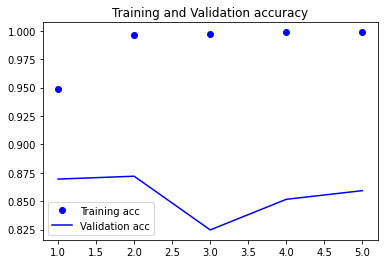

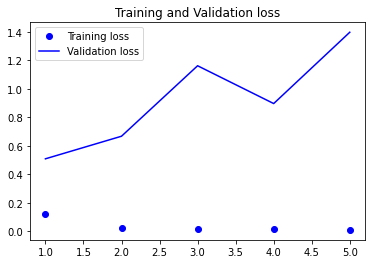

Train fold with 5822 images
label
NEGATIVE    1394
POSITIVE    4428
Name: label, dtype: int64

Validation fold with 1968 images
label
NEGATIVE     574
POSITIVE    1394
Name: label, dtype: int64
------------------------------

axis2
=====
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________
Found 5822 validated image filenames belonging to 2 classes.
Found 1968 validated image filenames belonging to 2 classes.
Epoch 1/5
36

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/users/nmlromero/.conda/envs/env-cnn/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-24498bfa44e8>", line 19, in <module>
    history = train_model(model, train_df, validation_df, EPOCHS, n_fold, cur_subfolder)
  File "<ipython-input-12-2df9ce8a0892>", line 13, in train_model
    history = model.fit(train_generator, # X_Train
  File "/home/users/nmlromero/.conda/envs/env-cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/users/nmlromero/.conda/envs/env-cnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "/home/users/nmlromero/.conda/envs/env-cnn/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 780, in

TypeError: object of type 'NoneType' has no len()

In [14]:
# Split into training/validation and TEST
data_tv, data_test = get_dataset_trainval_test(data, 'complement')

X = data_tv.index.to_list()
y = data_tv['int_covid'].to_list()
skf = StratifiedKFold(n_splits=4, shuffle=True)
skf.get_n_splits(X, y)
print(skf)
n_fold = 0
for train_index, validation_index in skf.split(X, y):
    #print("TRAIN:", train_index, "\nTEST:", test_index)
    n_fold += 1
    print("\n\n\nFold", str(n_fold))
    for cur_subfolder in SUB_FILE:
        train_df, validation_df = get_data_set(str(n_fold)+"fold", cur_subfolder, 
                                               data_tv.iloc[train_index, :], data_tv.iloc[validation_index, :])
        print('\n'+cur_subfolder+'\n=====')
        model, SELECTED_MODEL = get_model_vgg16()
        history = train_model(model, train_df, validation_df, EPOCHS, n_fold, cur_subfolder)
        
        #Plot Results
        plot_results(history, cur_subfolder, str(n_fold)+"fold", SELECTED_MODEL)


In [ ]:
def predictions_by_patient(model, patients):
    results = []
    for p in patients:
        curr_dir = VALIDATION_IMG_SRC_FOLDER + '/' + p + '/'
        imgs_filename = sorted(os.listdir(curr_dir))
        test_filenames = imgs_filename[:]
        test_df = pd.DataFrame({
                'filename': test_filenames
            })
        nb_samples = test_df.shape[0]

        test_gen = ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(IMG_WIDTH, IMG_HEIGHT),
                batch_size=16,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))
        test_df['category'] = [int(round(p[0])) for p in predict]
        results.append(test_df)

    for i,test_df in enumerate(results):
        print('Patient number: ', patients[i])
        if os.path.isfile('vgg_legend.npy'):
            print('loading label legend file')
            class_indices = np.load('vgg_legend.npy', allow_pickle=True).item()
            class_indices = dict((v,k) for k,v in class_indices.items())
            test_df['category'] = test_df['category'].replace(class_indices)
        print(test_df['category'].value_counts())
        print('')

In [ ]:
# train_df, validation_df = get_data_set(0, SUB_FILE[0], data_train, data_test)
# example_df = train_df.sample(n=1).reset_index(drop=True)
# example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")
# plt.figure(figsize = (12,12))
# for i in range(0, 9):
#         plt.subplot(3, 3, i+1)
#         for X_batch, Y_batch in example_generator:
#             image = X_batch[0]
#             plt.imshow(image)
#             break
# plt.tight_layout()
# plt.show()